In [309]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [310]:
train = pd.read_csv('train_0211.csv')
test = pd.read_csv('test_0211.csv')

In [311]:
train.head()

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,lead_owner,is_converted,customer_continent,customer_type_category,inquiry_category
0,1.0,Philippines,AS,0.066667,32160,End-Customer,Enterprise,NaN,0.0,0.0,...,less than 3 months,1,0,0.003079,0.026846,0,True,Asia,End-User,quotation/purchase
1,1.0,Philippines,AS,0.066667,23122,End-Customer,Enterprise,12.0,0.0,0.0,...,less than 3 months,1,0,0.003079,0.026846,1,True,Asia,End-User,quotation/purchase
2,1.0,India,AS,0.088889,1755,End-Customer,Enterprise,144.0,0.0,0.0,...,less than 3 months,1,0,0.003079,0.026846,2,True,Asia,End-User,product inquiry
3,1.0,India,AS,0.088889,4919,End-Customer,Enterprise,NaN,0.0,0.0,...,less than 3 months,1,0,0.003079,0.026846,3,True,Asia,End-User,quotation/purchase
4,1.0,India,AS,0.088889,17126,Specifier/Influencer,Enterprise,NaN,0.0,0.0,...,less than 3 months,0,0,0.003079,0.026846,4,True,Asia,Specifier/Influencer,quotation/purchase


In [312]:
test.head()

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,lead_owner,is_converted,customer_continent,customer_type_category,inquiry_category
0,0.00,Philippines,ID,0.073248,47466,End-Customer,Enterprise,53.0,0.0,0.0,...,unknown,1,0,0.001183,0.049840,278,0,Asia,End-User,uncategorized
1,0.25,Philippines,IT,0.000000,5405,End-Customer,SMB,NaN,0.0,0.0,...,unknown,0,0,0.000013,0.000000,437,1,Asia,End-User,quotation/purchase
2,1.00,India,ID,0.000000,13597,Specifier/Influencer,SMB,NaN,0.0,0.0,...,less than 3 months,0,0,0.000060,0.131148,874,0,Asia,Specifier/Influencer,quotation/purchase
3,0.50,India,ID,0.118644,17204,Others,Enterprise,NaN,0.0,0.0,...,more than a year,0,0,0.001183,0.049840,194,0,Asia,Others,quotation/purchase
4,1.00,India,ID,0.074949,2329,End-Customer,Enterprise,2.0,1.0,0.0,...,less than 3 months,1,1,0.003079,0.064566,167,0,Asia,End-User,quotation/purchase


In [313]:
train.drop(columns=['historical_existing_cnt', 'customer_job'], inplace=True)
test.drop(columns=['historical_existing_cnt', 'customer_job'], inplace=True)

# 카테고리 별 전환율 생성 함수

In [314]:
# def add_conversion_rate(df, group_column):
    
#     df[f'{group_column}_converted_rate'] = df.groupby(group_column)['is_converted'].transform('mean')
    
#     return df

In [315]:
def add_conversion_rate(df_train, df_test, group_column):
    # train 데이터에서 각 그룹의 전환율 계산
    group_conversion_rates = df_train.groupby(group_column)['is_converted'].mean()
    
    # train 데이터에 계산된 전환율을 맵핑하여 새로운 컬럼 생성
    df_train[f'{group_column}_converted_rate'] = df_train[group_column].map(group_conversion_rates)
    
    # test 데이터에도 train 데이터에서 계산된 전환율을 맵핑하여 새로운 컬럼 생성
    df_test[f'{group_column}_converted_rate'] = df_test[group_column].map(group_conversion_rates)
    
    return df_train, df_test

# 카테고리 별 전환율 시각화

In [316]:
def plot_conversion_rate(df, group_column):

    # Calculate conversion rates for each group
    conversion_rates = df.groupby(group_column)['is_converted'].mean().nlargest(20)
    
    plt.figure(figsize=(10, 6))
    conversion_rates.plot(kind='bar', color='skyblue')
    plt.title(f'Conversion Rate by {group_column}')
    plt.xlabel(group_column)
    plt.ylabel('Conversion Rate')
    plt.xticks(rotation=90)
    plt.show()

## customer_continent별 전환율

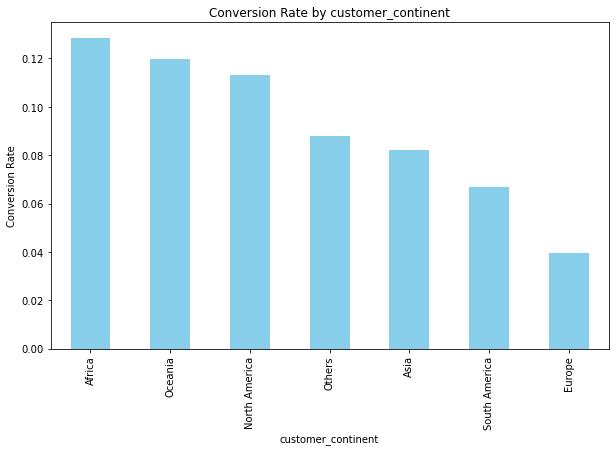

In [317]:
train, test = add_conversion_rate(train, test, 'customer_continent')
plot_conversion_rate(train, 'customer_continent')

## customer_idx별 전환율

In [318]:
def get_customer_converted_rate(df, conversion_rates=None):
    if conversion_rates is None:
        conversion_rates = {}
        for customer_idx in df['customer_idx'].unique():
            conversions = df[(df['customer_idx'] == customer_idx) & (df['is_converted'] == True)].shape[0]
            total = df[df['customer_idx'] == customer_idx].shape[0]
            conversion_rates[customer_idx] = conversions / total if total > 0 else 0
    
    df['customer_idx_converted_rate'] = df['customer_idx'].map(conversion_rates).fillna(0)
    
    return df, conversion_rates

train, customer_idx_converted_rate = get_customer_converted_rate(train)
test, _ = get_customer_converted_rate(test, customer_idx_converted_rate)

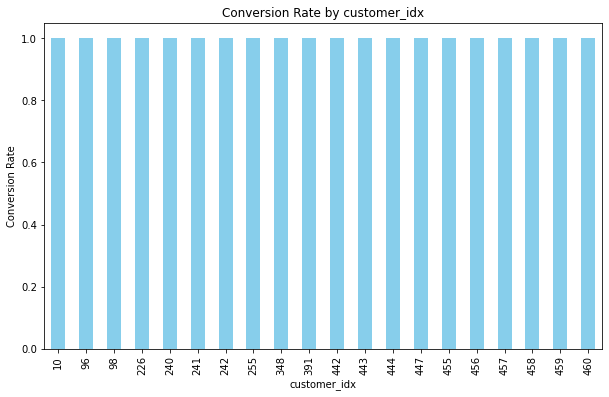

In [319]:
# train, test = add_conversion_rate(train, test, 'customer_idx')
plot_conversion_rate(train, 'customer_idx')

## customer_type_category별 전환율

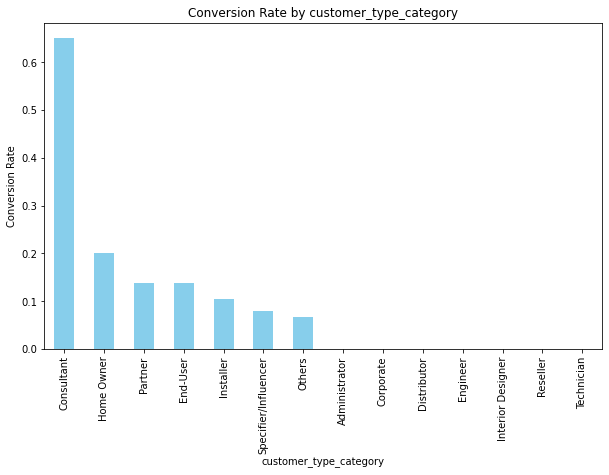

In [320]:
train, test = add_conversion_rate(train, test, 'customer_type_category')
plot_conversion_rate(train, 'customer_type_category')

## customer_position별 전환율

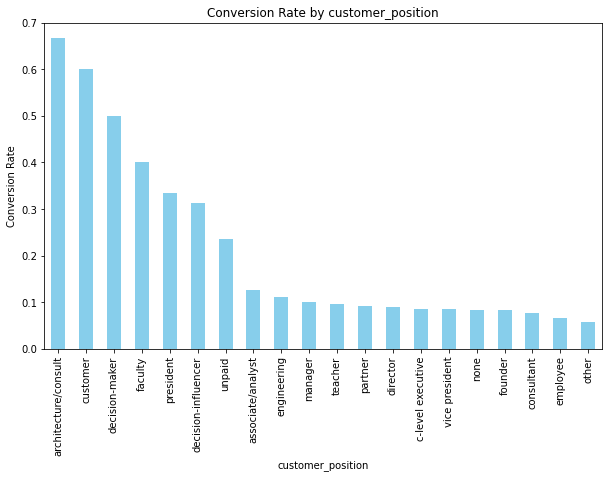

In [321]:
train, test = add_conversion_rate(train, test, 'customer_position')
plot_conversion_rate(train, 'customer_position')

## business_unit별 전환율

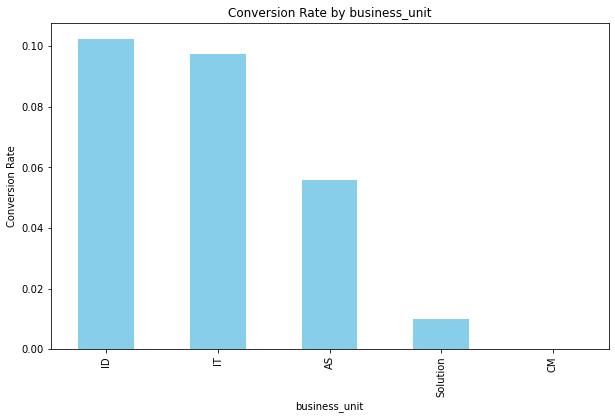

In [322]:
train, test = add_conversion_rate(train, test, 'business_unit')
plot_conversion_rate(train, 'business_unit')

## response_corporate별 전환율 

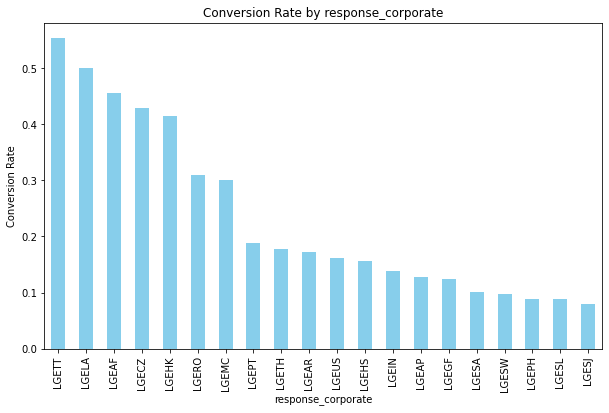

In [323]:
train, test = add_conversion_rate(train, test, 'response_corporate')
plot_conversion_rate(train, 'response_corporate')

In [324]:
train.loc[train['response_corporate']=='LGEPH', 'customer_country'].value_counts()

Philippines     2612
Others            31
Iraq               2
Cambodia           2
Brazil             1
Qatar              1
Saudi Arabia       1
Puerto Rico        1
Name: customer_country, dtype: int64

## lead_owner별 전환율

In [325]:
def get_lead_owner_converted_rate(df, conversion_rates=None):
    if conversion_rates is None:
        conversion_rates = {}
        for lead_owner in df['lead_owner'].unique():
            conversions = df[(df['lead_owner'] == lead_owner) & (df['is_converted'] == True)].shape[0]
            total = df[df['lead_owner'] == lead_owner].shape[0]
            conversion_rates[lead_owner] = conversions / total if total > 0 else 0
    
    df['lead_owner_converted_rate'] = df['lead_owner'].map(conversion_rates).fillna(0)
    
    return df, conversion_rates

train, lead_owner_converted_rate = get_lead_owner_converted_rate(train)
test, _ = get_lead_owner_converted_rate(test, lead_owner_converted_rate)

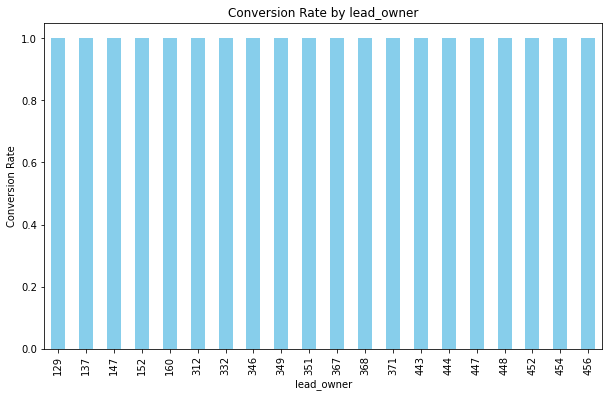

In [326]:
# train, test = add_conversion_rate(train, test, 'lead_owner')
plot_conversion_rate(train, 'lead_owner') 

## product_category별 전환율

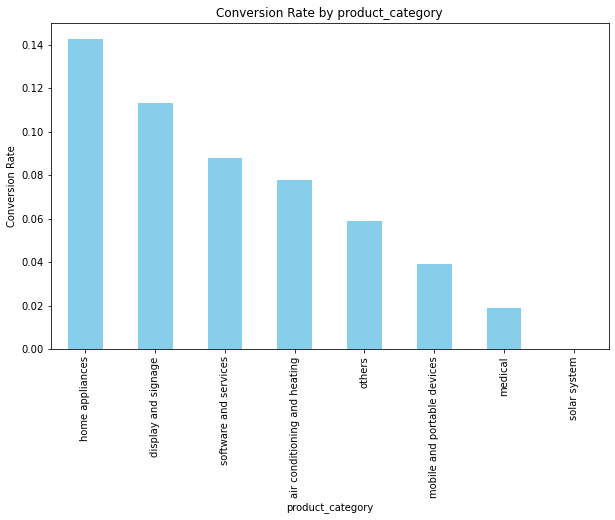

In [327]:
train, test = add_conversion_rate(train, test, 'product_category')
plot_conversion_rate(train, 'product_category')

## inquiry_category별 전환율

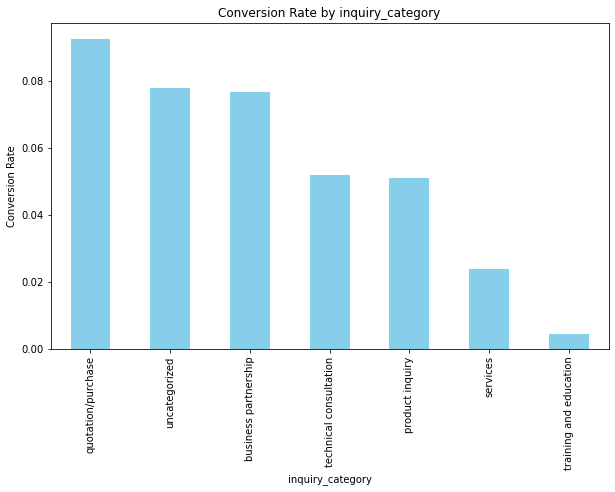

In [328]:
train, test = add_conversion_rate(train, test, 'inquiry_category')
plot_conversion_rate(train, 'inquiry_category')

## bant_submit별 전환율

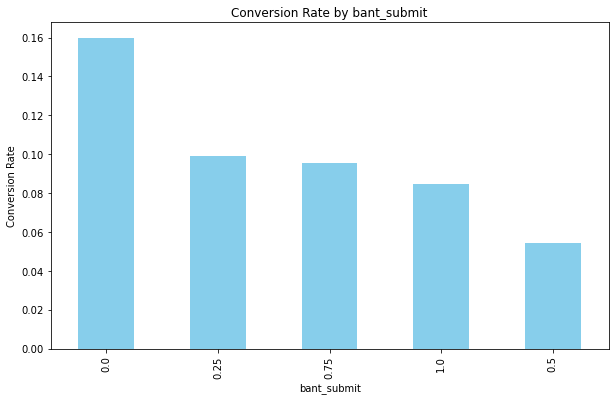

In [329]:
train, test = add_conversion_rate(train, test, 'bant_submit')
plot_conversion_rate(train, 'bant_submit')

## expected_timeline별 전환율

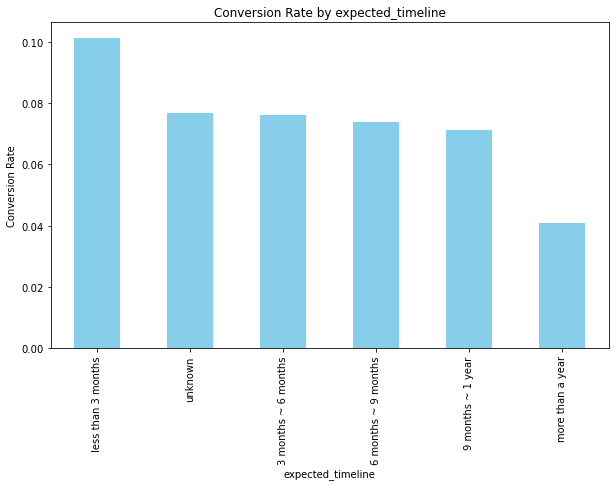

In [330]:
train, test = add_conversion_rate(train, test, 'expected_timeline')
plot_conversion_rate(train, 'expected_timeline') 

## enterprise별 전환율

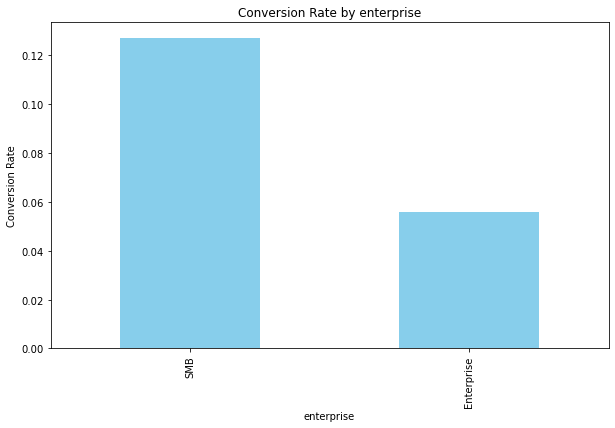

In [331]:
train, test = add_conversion_rate(train, test, 'enterprise')
plot_conversion_rate(train, 'enterprise') 

# ver_win_rate_x과 ver_win_ratio_per_bu의 전환율 0.3 이상인 값에 가중치? >> X
- train과 test의 unique가 일치함
- ver_win_rate_x == 6.04403367e-05
- ver_win_ratio_per_bu == 0.28571429

### ver_win_rate_x

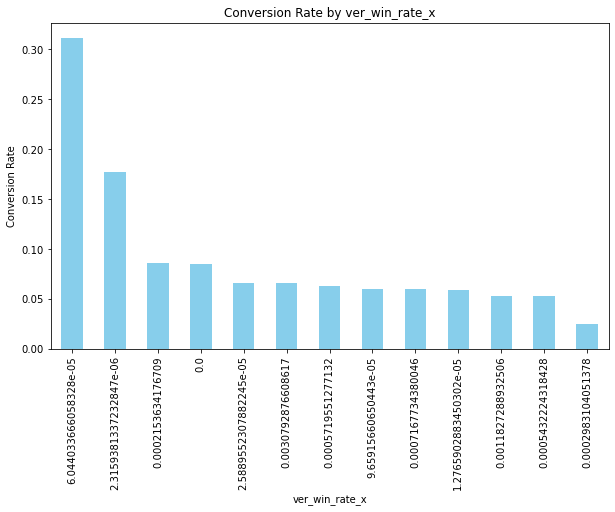

In [332]:
plot_conversion_rate(train, 'ver_win_rate_x') 

In [357]:
train['ver_win_rate_x'].value_counts()

0.000000    40882
0.003079     4097
0.001183     3011
0.000717     2013
0.000543     1929
0.000298     1818
0.000572     1727
0.000060     1199
0.000215     1035
0.000097      650
0.000026      519
0.000013      306
0.000002      113
Name: ver_win_rate_x, dtype: int64

### ver_win_ratio_per_bu

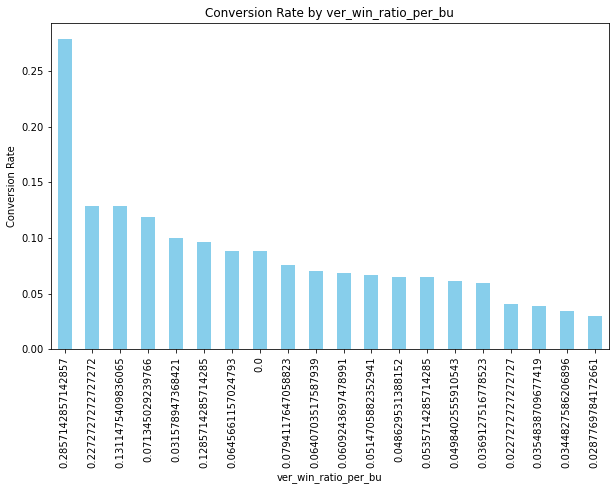

In [335]:
plot_conversion_rate(train, 'ver_win_ratio_per_bu') 

In [356]:
train['ver_win_ratio_per_bu'].value_counts()

0.000000    43995
0.064566     2460
0.049840     2028
0.020121     1365
0.048630     1356
0.026846     1278
0.064070     1075
0.071345      984
0.011583      788
0.022634      713
0.060924      540
0.079412      421
0.036913      403
0.035484      385
0.031579      271
0.053571      216
0.051471      210
0.028777      200
0.022727      173
0.128571      156
0.131148      148
0.227273       62
0.285714       43
0.034483       29
Name: ver_win_ratio_per_bu, dtype: int64

# historical_existing_cnt

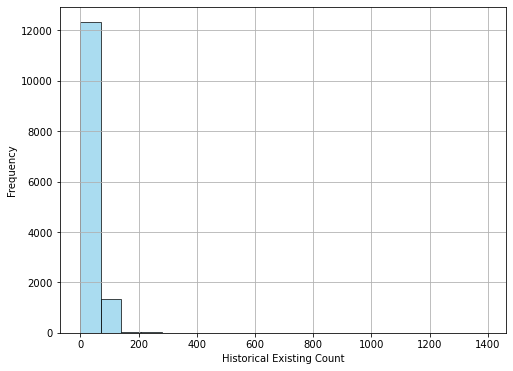

In [81]:
# plt.figure(figsize=(8, 6))
# train['historical_existing_cnt'].dropna().hist(bins=20, color='skyblue', edgecolor='black', alpha=0.7)
# plt.xlabel('Historical Existing Count')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()

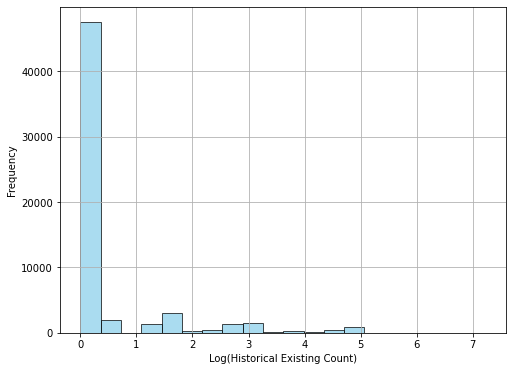

In [94]:
# plt.figure(figsize=(8, 6))
# plt.hist(np.log1p(train['historical_existing_cnt']), bins=20, color='skyblue', edgecolor='black', alpha=0.7)
# plt.xlabel('Log(Historical Existing Count)')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()

In [99]:
# train.loc[train['historical_existing_cnt']==1394.0, 'is_converted']

26689    False
Name: is_converted, dtype: bool

# lead_desc_length 로그변환 전후에 따른 is_converted 분포

### 로그변환 전

In [359]:
train['lead_desc_length'] = np.exp(train['lead_desc_length'])

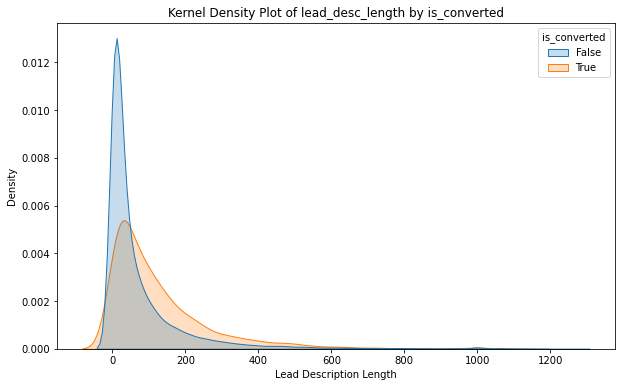

In [360]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=train, x='lead_desc_length', hue='is_converted', fill=True, common_norm=False)
plt.title('Kernel Density Plot of lead_desc_length by is_converted')
plt.xlabel('Lead Description Length')
plt.ylabel('Density')
plt.show()

### 로그변환 후

In [361]:
train['lead_desc_length'] = np.log(train['lead_desc_length'])

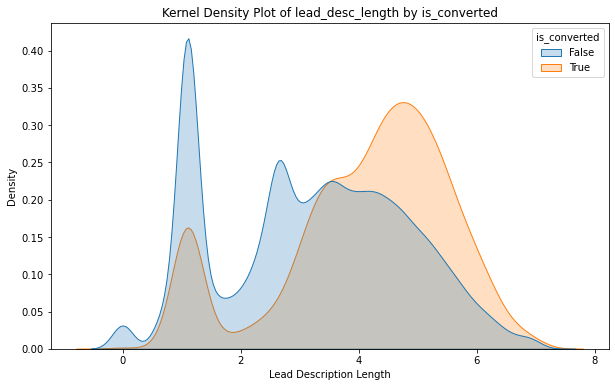

In [362]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=train, x='lead_desc_length', hue='is_converted', fill=True, common_norm=False)
plt.title('Kernel Density Plot of lead_desc_length by is_converted')
plt.xlabel('Lead Description Length')
plt.ylabel('Density')
plt.show()

# 특정 business_area에 가중치를 부여 -> business_area 컬럼 drop X
- ver_pro==1인 business_area: 'corporate / office', 'retail', 'hotel & accommodation' & product_category = 'display and signage'

- ver_cus==1인 business_area: 'corporate / office', 'retail', 'hotel & accommodation', 'education' & 'End-user'
- it_stategic_ver==1인 business_area: 'corporate / office', 'hotel & accommodation'
- id_stategic_ver==1인 business_area: 'corporate / office', 'hotel & accommodation'
### 가중치: business_area: 'corporate / office', 'hotel & accommodation', product_category: 'display and signage', customer_type='end_user

In [363]:
raw = pd.read_csv('train.csv')
raw_test = pd.read_csv('submission.csv')

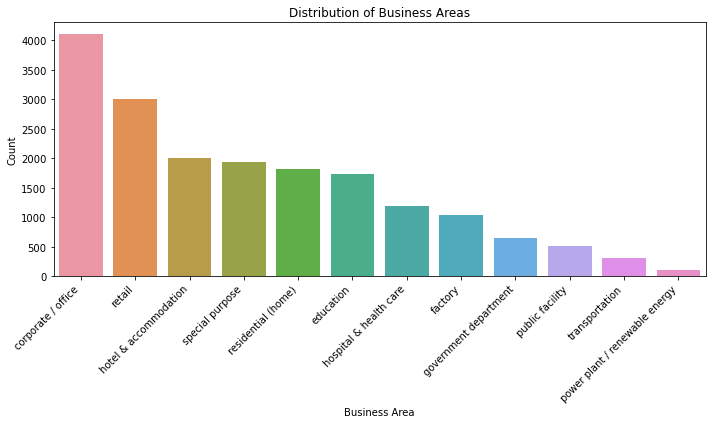

In [364]:
business_area_counts = raw['business_area'].value_counts()

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=business_area_counts.index, y=business_area_counts.values)
plt.title('Distribution of Business Areas')
plt.xlabel('Business Area')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

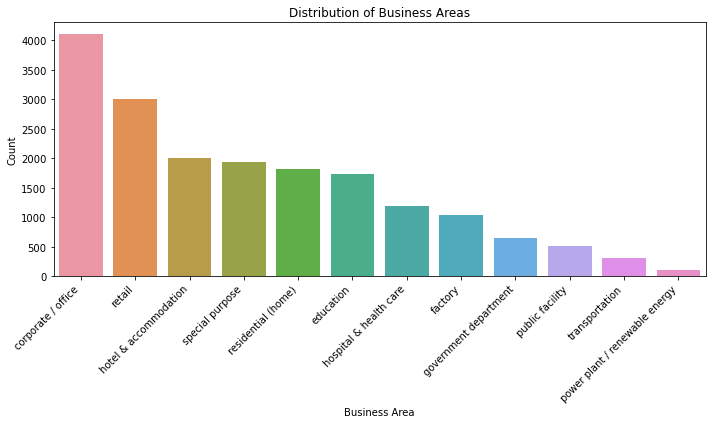

In [365]:
business_area_counts_test = raw_test['business_area'].value_counts()

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=business_area_counts.index, y=business_area_counts.values)
plt.title('Distribution of Business Areas')
plt.xlabel('Business Area')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [366]:
raw['business_area'].fillna('others', inplace=True)
raw_test['business_area'].fillna('others', inplace=True)

In [367]:
train['business_area'] = raw['business_area']
test['business_area'] = raw_test['business_area']

## business_area별 전환율

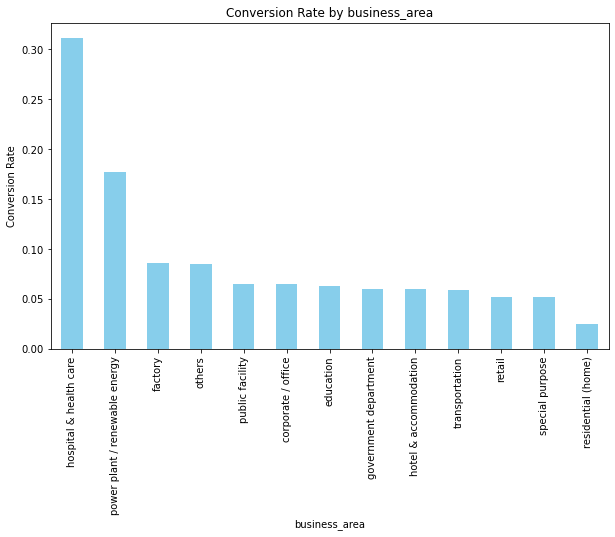

In [368]:
train, test = add_conversion_rate(train, test, 'business_area')
plot_conversion_rate(train, 'business_area') 

# 상관분석
- lead_owner_converted_rate(0.62)와 customer_idx_converted_rate(0.97)가 타겟변수와의 상관관계가 크다
- lead_owner_converted_rate와 customer_idx_converted_rate끼리도 상관관계가 있다

## train

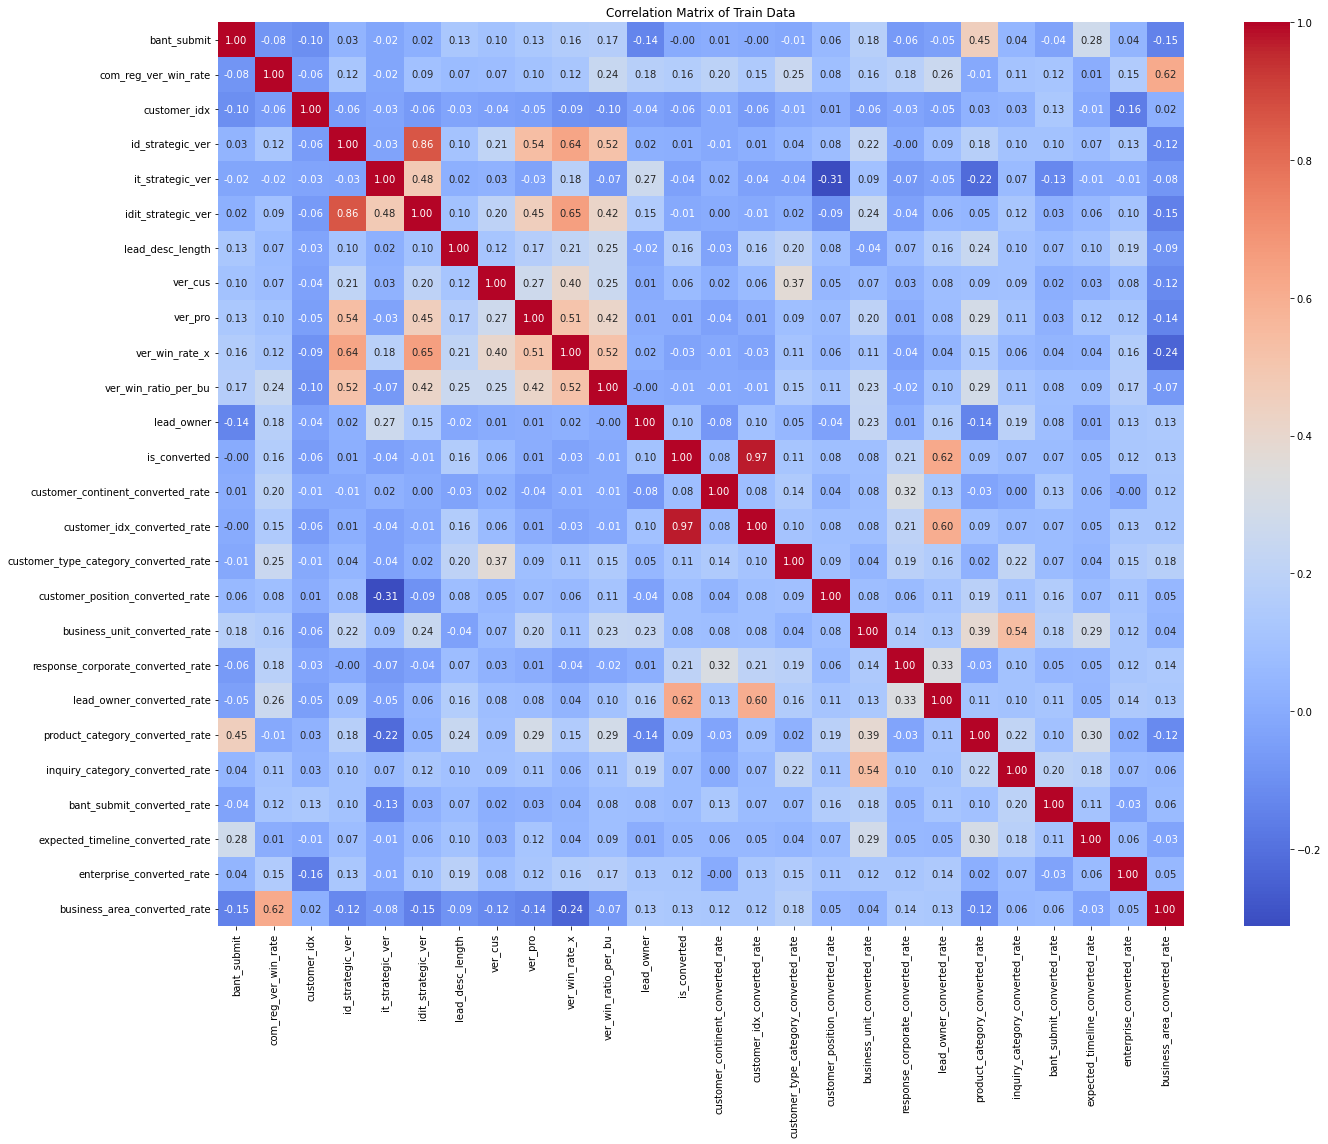

In [304]:
# Train 데이터와 Test 데이터의 상관 행렬을 계산합니다.
correlation_matrix_train = train.corr()

# 상관 행렬을 시각화합니다.
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix_train, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Train Data')

plt.tight_layout()
plt.show()

## test

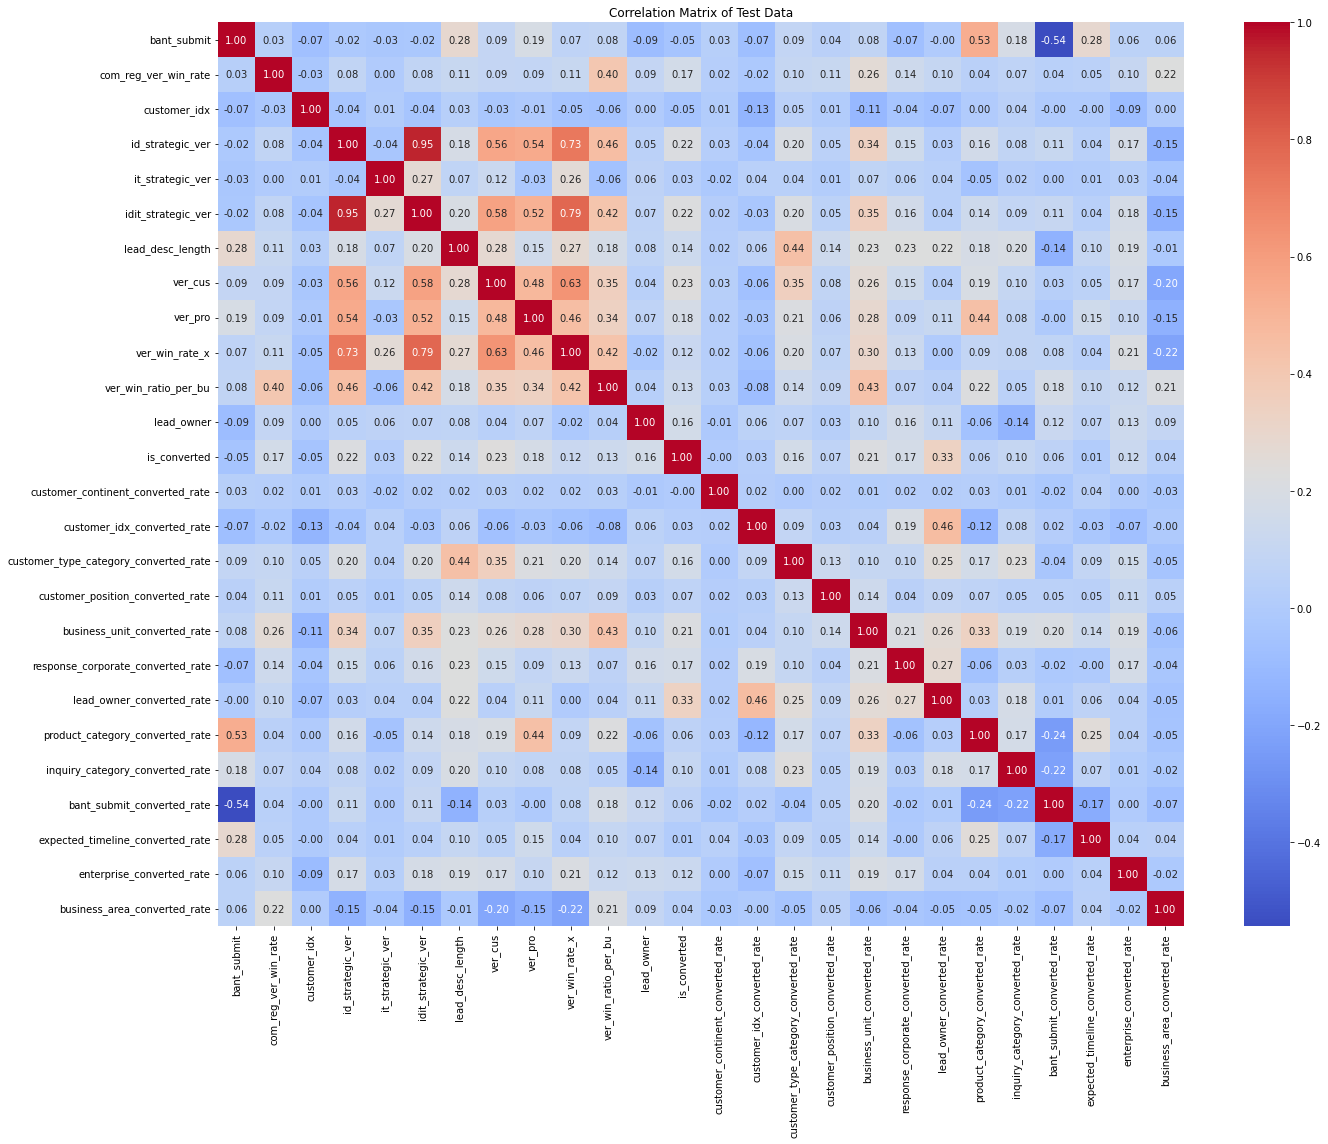

In [370]:
correlation_matrix_test = test.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix_test, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Test Data')

plt.tight_layout()
plt.show()

## train+test

<AxesSubplot:>

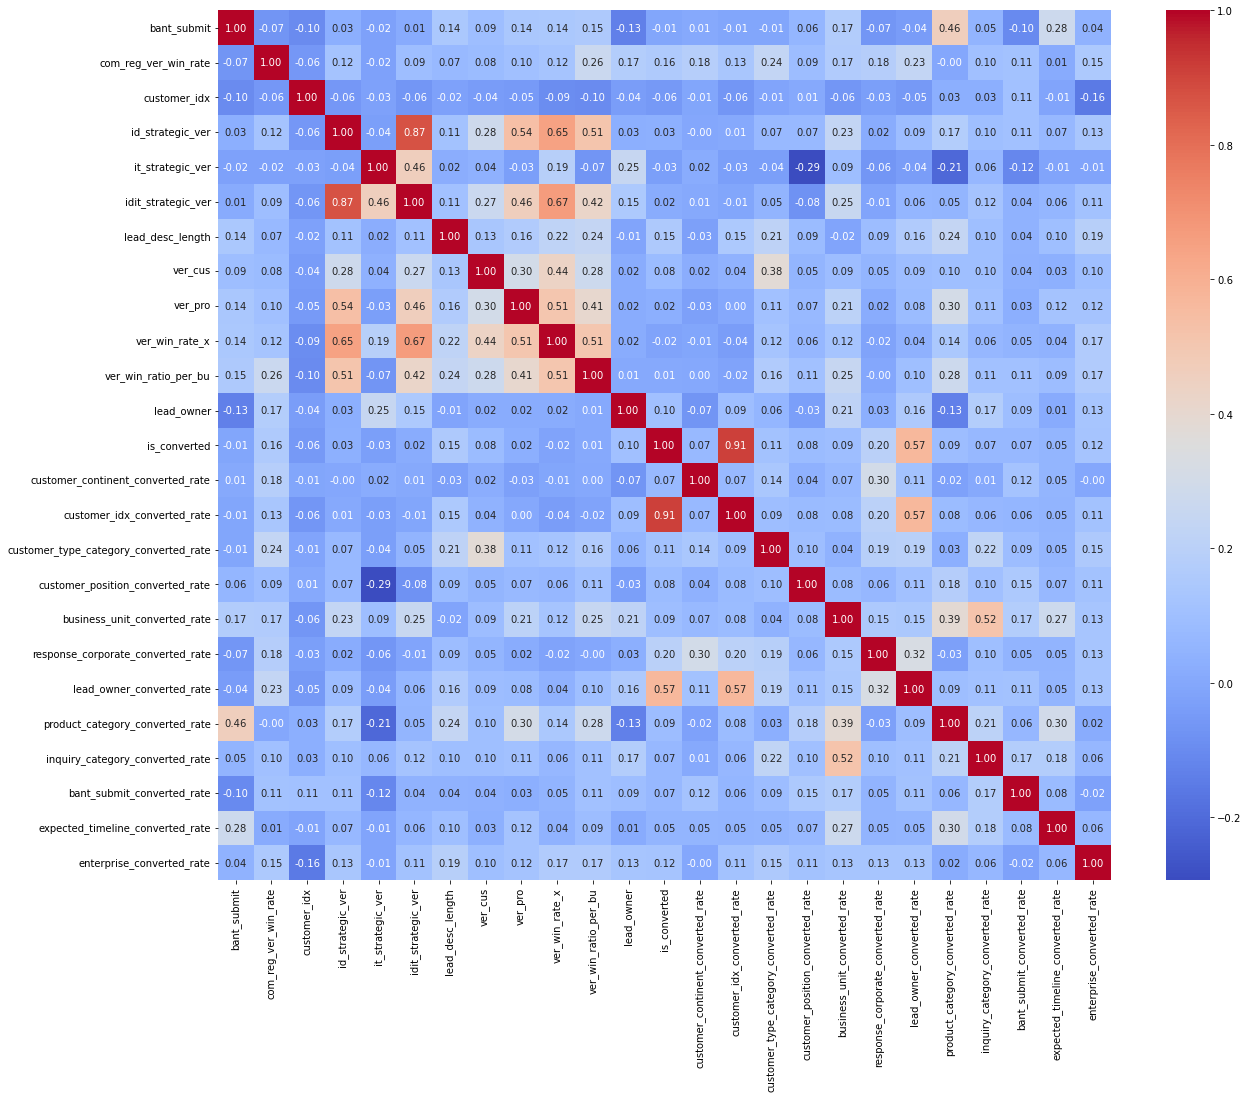

In [340]:
combined_data = pd.concat([train, test], keys=['train', 'test'])
plt.figure(figsize=(20, 16))
sns.heatmap(combined_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")